**Aim**: Finding the best fit of the rotation curve of a disk galaxy and determine the mass of the dark matter halo.

There are two data file extract from the web app. `NGC2403_rot_cur.txt` and `UGC128_rot_cur.txt`

There are **three** parameters to fit:
- Halo Central Density: 0~500 Solar masses/(10pc)^3
- Halo Core Radius: 0~5 kpc
- Disk Mass to Light Ratio: 0~5 solar masses/solar luminosity

You can use [The web app](http://pages.pomona.edu/~tmoore/RotCurve/) to get the best fit or write a python code to fit them.

[The theory web](https://pages.pomona.edu/~tmoore/RotCurve/Website/) is here.

Notice: 
- we use a slightly <font color=red>different</font> formular to calculate the rotation of disk compare to the app
- Be careful to the parameters' units. 

$$V_{tot}^2=V_{halo}^2+V_{disk}^2$$
$$V_{halo}^2(r)=4\pi G \rho_0r^2_c\bigg[1-\frac{r_c}{r}arctan(\frac{r}{r_c})\bigg]$$
$$V_{disk}(r)=0.85*\sqrt{G\times M2L \times L/R_0}\sqrt{\frac{\tilde{r}^{1.3}}{1+\tilde{r}^{2.3}}}\qquad \tilde{r}=0.533/2\times r/R_0$$
- R0 in unit of parsec
- the rest is in the unit of SI unit

```python
# in SI unit
m_solar=1.98847e30      # kg
pc=3.08567758e16        # m
kpc=pc*1e3
G=6.67430*1e-11
pi=np.pi

# N2403
L_N2403=2.45*1e9        # Luminosity of sun
R0_N2403=1              # kpc

# U128
L_U128=1.95*1e9         # Luminosity of sun
R0_U128=3.5             # kpc
```

**Some considerations when completing with Python**
- Recommended method: **least square method** with `scipy.optimize.curve_fit`, **Markov Chain Monte Carlo (MCMC)** with `emcee`, **maximum likelihood estimation**
- Read the data: we suggest you use `pandas` to read the data with following codes
```python
N2403_data=pd.read_csv('NGC2403_rot_cur.txt',skiprows=1,names=['R_kpc','vrot_km/s,'vrot_err'],sep='\s+')
```
- when using `scipy.optimize.curve_fit` to get the best fit, pay attention to the following parameters: (for more details clicks this [website](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html))
  - `sigma`: the uncertainty in ydata, which will affects the calculation of the optimized function.
  - `p0`: the initial guess value of the parameters.
  - `bounds`: Lower and upper bounds on parameters.

**Some open questions**
- What happens if you don't set the boundary of the parameters. Which one do you think it's more reasonable, the fitting with bounded parameters or the one without, and why?
- Can you write a more accurate way to calculate the V_disk with following equation. See [The theory web](https://pages.pomona.edu/~tmoore/RotCurve/Website/) **APPLET PHYSICS**

$$V_{disk}^2(r)=4\pi G \gamma^* L(r) \ hy^2[I_0(y)K_0(y)-I_1(y)K_1(y)]$$

$\gamma^*$: disk mass-to-light ratio

$L(r)$: radial luminosity profile $\propto exp(-r/h)$, h is disk scale length

y=r/2h, I and K are Bessel fuction


---
**The answer with least square method**
- Remember to discuss the results (omitted here)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

In [2]:
# in SI unit
m_solar=1.98847e30      # kg
pc=3.08567758e16        # m
kpc=pc*1e3
G=6.67430*1e-11
pi=np.pi

# N2403
L_N2403=2.45*1e9        # Luminosity of sun
R0_N2403=1              # kpc

# U128
L_U128=1.95*1e9         # Luminosity of sun
R0_U128=3.5             # kpc

In [111]:
def read_data(f_loc):
    f=open(f_loc)
    data=f.read().split('\n')
    df=pd.DataFrame(columns=['R_kpc','vrot_km/s','vrot_err'],dtype=np.float64)
    for i in range(1,len(data)):
        temp_str_ls=data[i].split(' ')
        temp_ls=[]
        for item in temp_str_ls:
            if item!='':
                temp_ls.append(eval(item))
        df.loc[i,:]=temp_ls
    return df

def get_Vdisk(r,M2L,L0,R0):
    # r: per kilo parsecs
    # R0: per kilo parsecs
    # v: km/s
    r_tilde=0.533/2*r/R0
    cal1=np.sqrt(r_tilde**1.3/(1+r_tilde**2.3))
    vdisk=0.85*np.sqrt(M2L*G*m_solar*L0/(R0*kpc))*cal1/1e3
    return vdisk

def get_Vhalo(r,rho0,rc):
    # r: per kilo parsecs
    # rho0: solar mass/(10pc)^3
    # rc: per kilo parsecs
    rho0_SI=rho0*m_solar/(10*pc)**3
    rc_SI=rc*kpc
    vhalo=np.sqrt(4*pi*G*rho0_SI*rc_SI**2*(1-rc/r*np.arctan(r/rc)))/1e3
    return vhalo

def get_Vtot(vhalo,vdisk):
    vtot=np.sqrt(vhalo**2+vdisk**2)
    return vtot

def func_to_fit_N2403(r,rho0,rc,M2L):
    vhalo=get_Vhalo(r,rho0,rc)
    vdisk=get_Vdisk(r,M2L,**{'L0':L_N2403,'R0':R0_N2403})
    vtot=get_Vtot(vhalo,vdisk)
    return vtot

def func_to_fit_U128(r,rho0,rc,M2L):
    vhalo=get_Vhalo(r,rho0,rc)
    vdisk=get_Vdisk(r,M2L,**{'L0':L_U128,'R0':R0_U128})
    vtot=get_Vtot(vhalo,vdisk)
    return vtot    

def get_chi2(real,err,pred):
    chi2=np.sum(((real-pred)/err)**2)
    return chi2

def get_plot(df,popt,chi2,title_str,save_loc=None):
    legend_str='$\\rho_0$: {:<.0f}$M_\odot/(10pc)^3$\n$R_c$: {:<.2f}kpc\nM2L: {:<.2f}\n$\chi^2$: {:<.2f}'.format(*popt,chi2)
    plt.figure(figsize=(8,6),dpi=300)
    plt.errorbar(df.R_kpc,df['vrot_km/s'],df['vrot_err'],fmt='o--',label='obs_data')
    plt.plot(df.R_kpc,df.vdisk,color='green',label='Disk')
    plt.plot(df.R_kpc,df.vhalo,color='orange',label='Halo')
    plt.plot(df.R_kpc,df.vrot_pred,color='red',label='Total')
    plt.legend(title=legend_str)
    plt.title(title_str)
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.xlabel('Radius in kpc')
    plt.ylabel('Rotation speed in km/s')
    plt.minorticks_on()
    plt.tight_layout()
    if type(save_loc)==str: plt.savefig(save_loc)
    plt.show()
    return None

def get_plot_with_diff(df,popt,chi2,title_str,save_loc=None,xlim=None):
    legend_str='$\\rho_0$: {:<.0f}$M_\odot/(10pc)^3$\n$R_c$: {:<.2f}kpc\nM2L: {:<.2f}\n$\chi^2$: {:<.2f}'.format(*popt,chi2)
    fig,ax=plt.subplots(2,1,figsize=(16,9),dpi=300,sharex=True)
    ax[0].errorbar(df.R_kpc,df['vrot_km/s'],df['vrot_err'],fmt='o--',label='obs_data')
    ax[0].plot(df.R_kpc,df.vdisk,color='green',label='Disk')
    ax[0].plot(df.R_kpc,df.vhalo,color='orange',label='Halo')
    ax[0].plot(df.R_kpc,df.vrot_pred,color='red',label='Total')
    ax[0].set_ylim(bottom=0)
    ax[0].set_ylabel('Rotation speed in km/s')
    ax[0].set_title(title_str)
    ax[0].legend(title=legend_str)
    ax[1].plot(df['R_kpc'],df['vrot_km/s']-df['vrot_pred'],'*',label='vrot: true-pred')
    ax[1].minorticks_on()
    ax[1].set_xlim(xlim)
    ax[1].set_xlabel('Radius in kpc')
    ax[1].set_ylabel('difference between true & pred in km/s')
    ax[1].legend()
    if xlim!=None: ax[1].hlines(0,xlim[0],xlim[1],'r',linestyle='dashed')
    fig.tight_layout()
    if type(save_loc)==str: plt.savefig(save_loc)
    plt.show()
    return None

In [112]:
df=read_data('NGC2403_rot_cur.txt')
popt,pocv=curve_fit(func_to_fit_N2403,df['R_kpc'].values,df['vrot_km/s'].values,\
    sigma=df['vrot_err'].values,bounds=([0,0,0],[500,5,5]))
df['vdisk']=get_Vdisk(df['R_kpc'].values,popt[2],**{'L0':L_N2403,'R0':R0_N2403})
df['vhalo']=get_Vhalo(df['R_kpc'].values,popt[0],popt[1])
df['vrot_pred']=get_Vtot(df['vhalo'].values,df['vdisk'].values)
chi2=get_chi2(df['vrot_km/s'].values,df['vrot_err'].values,df['vrot_pred'].values)

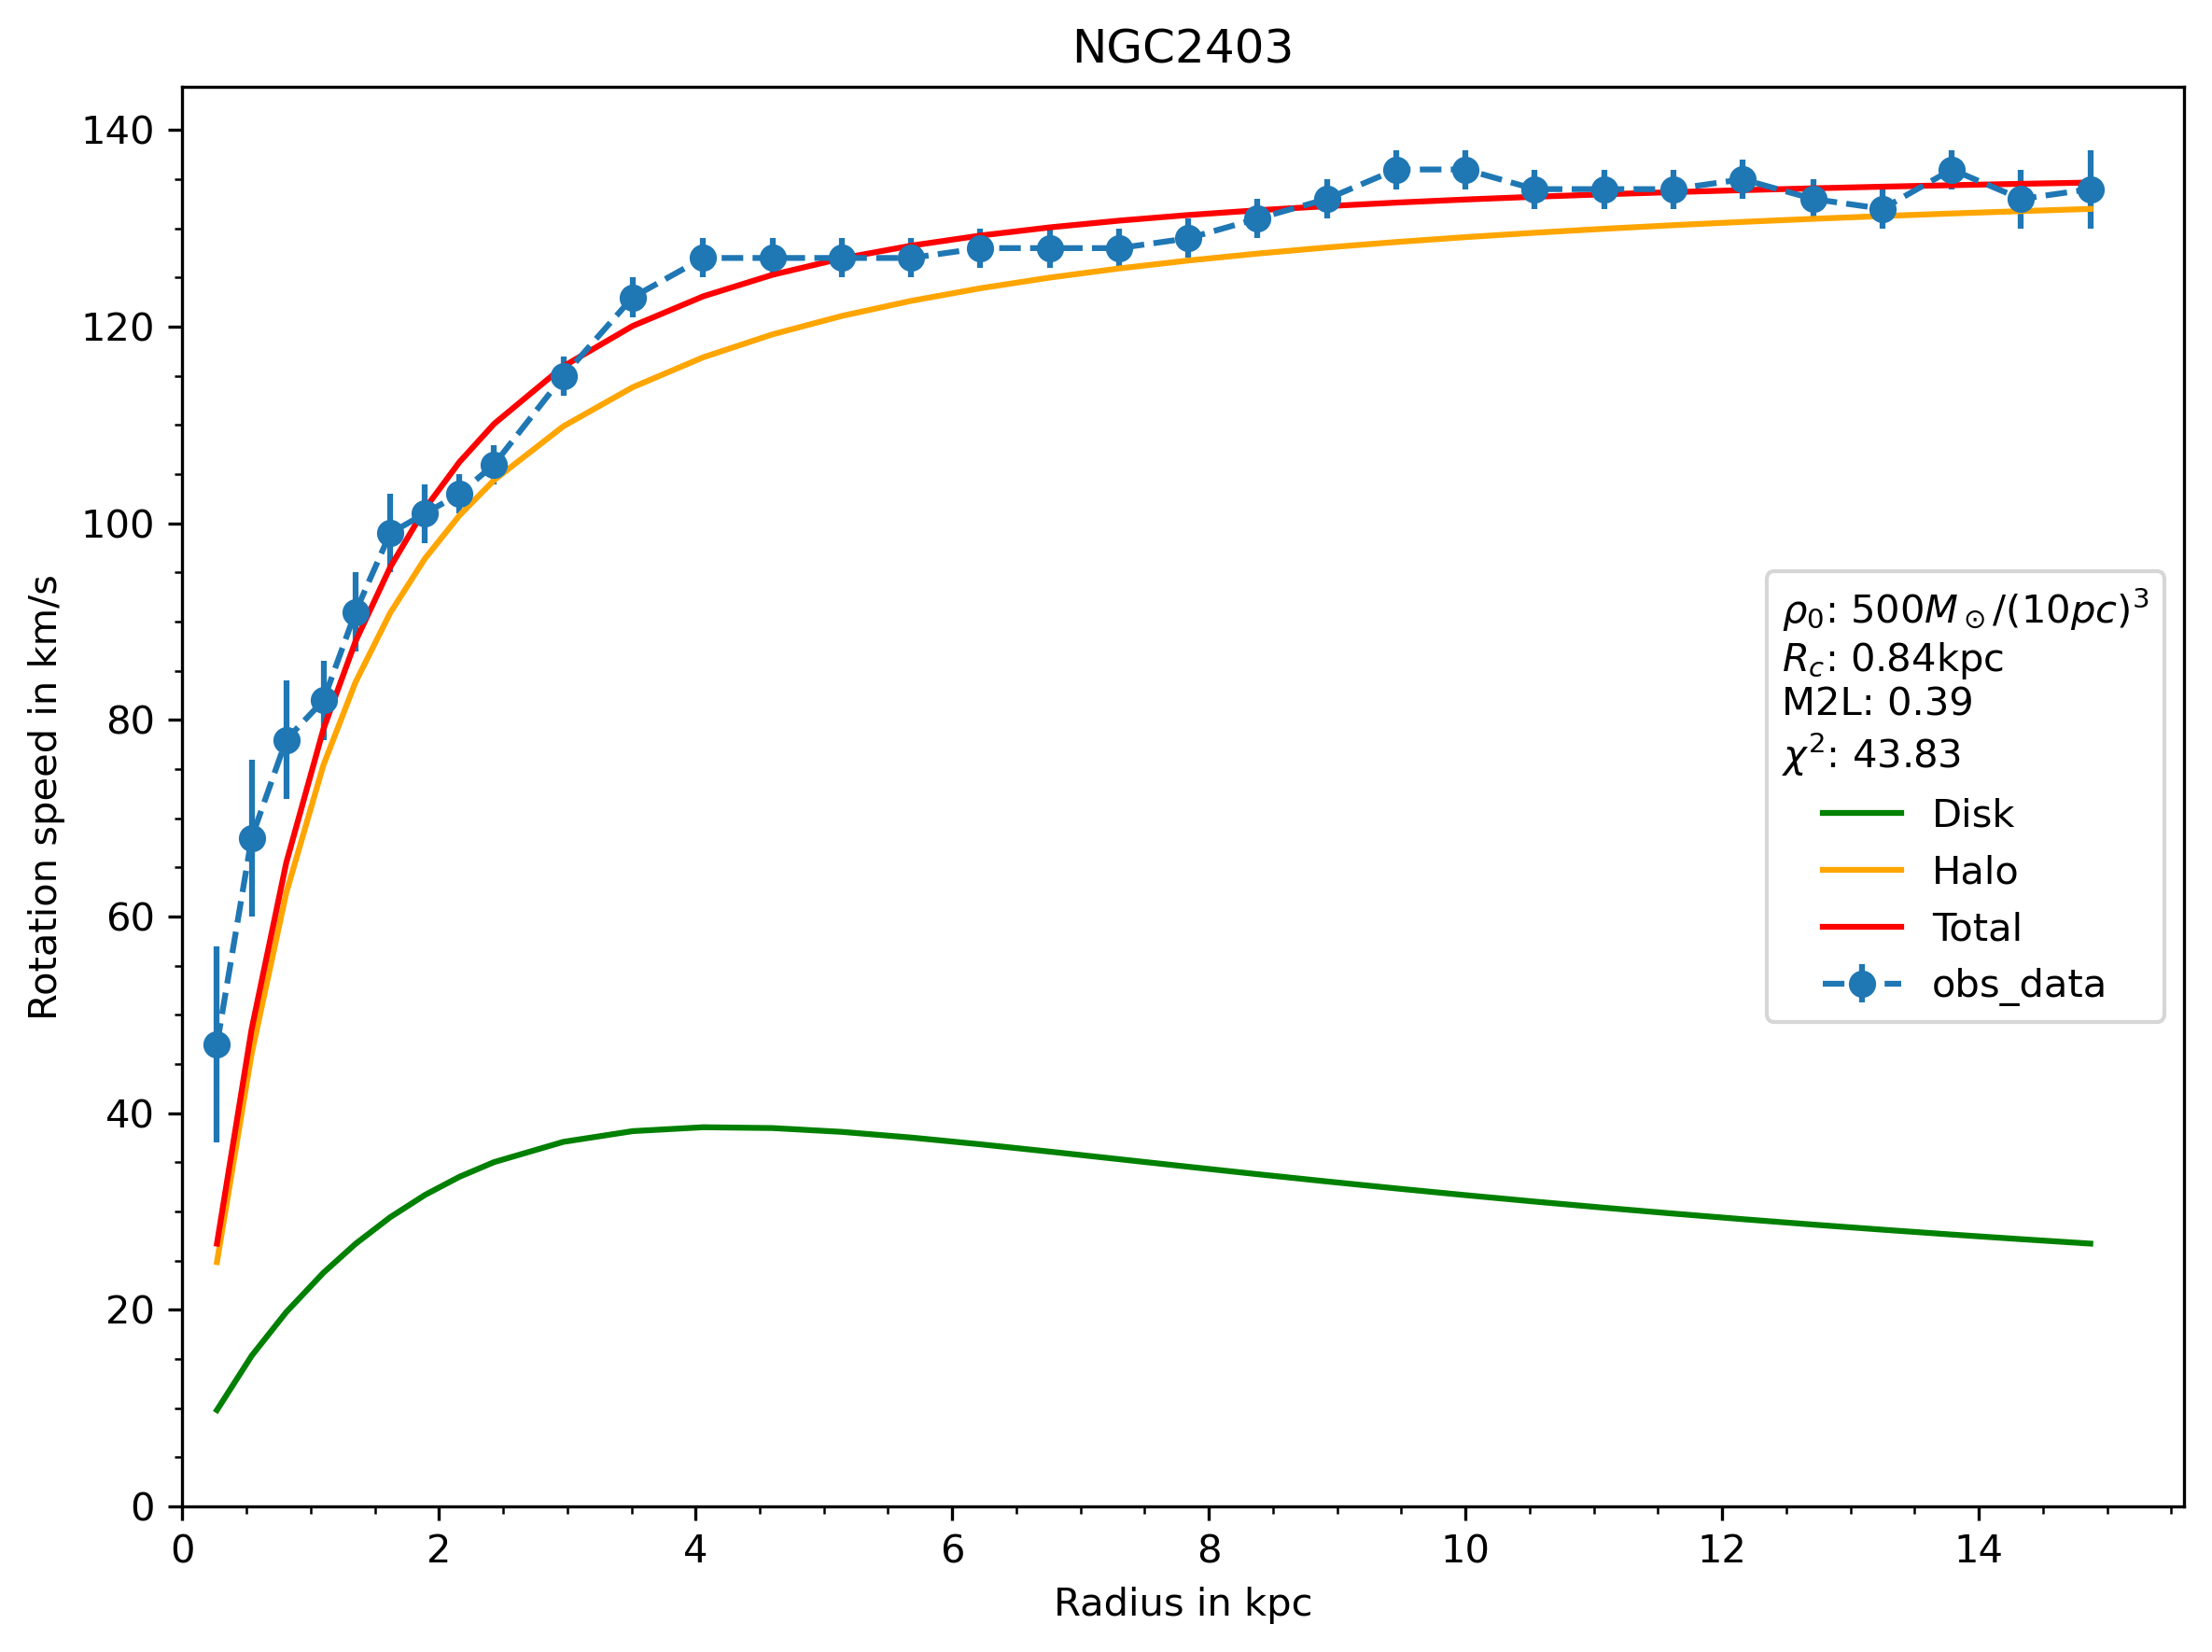

In [113]:
get_plot(df,popt,chi2,title_str='NGC2403')

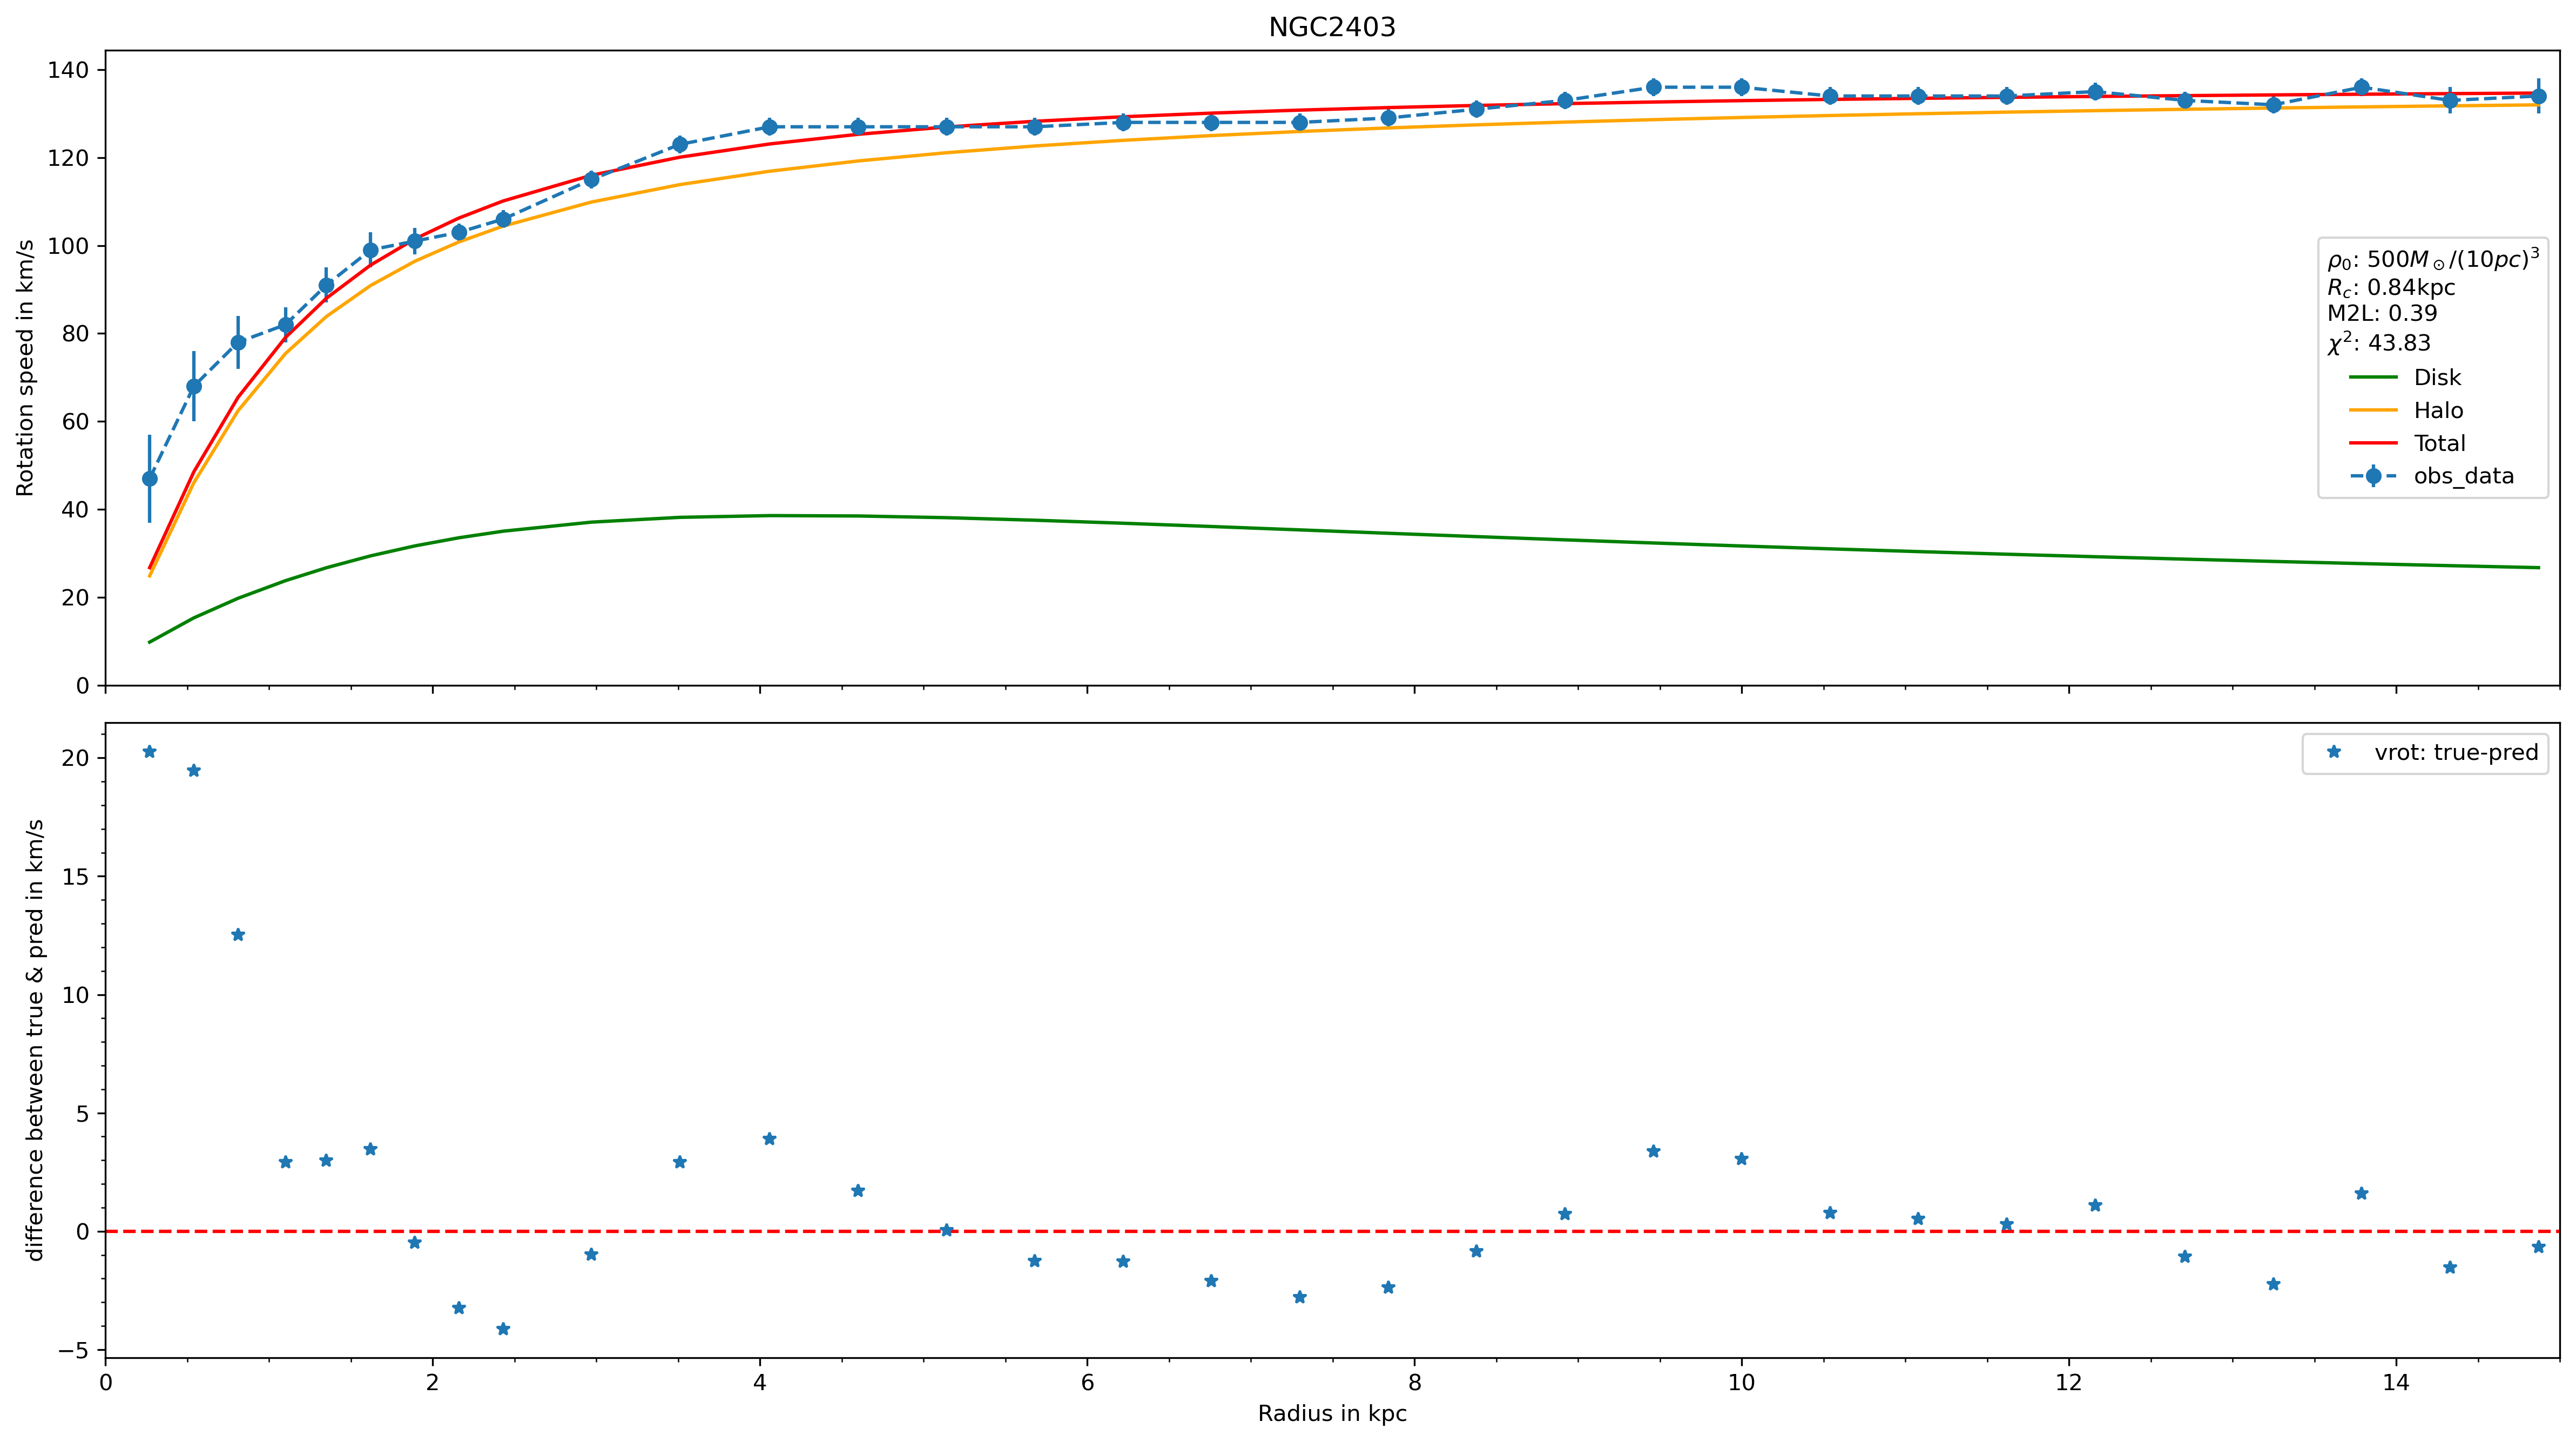

In [114]:
get_plot_with_diff(df,popt,chi2,title_str='NGC2403',xlim=(0,15))

In [115]:
df=read_data('UGC128_rot_cur.txt')
popt,pocv=curve_fit(func_to_fit_N2403,df['R_kpc'].values,df['vrot_km/s'].values,\
    sigma=df['vrot_err'].values,bounds=([0,0,0],[500,5,5]))
df['vdisk']=get_Vdisk(df['R_kpc'].values,popt[2],**{'L0':L_U128,'R0':R0_U128})
df['vhalo']=get_Vhalo(df['R_kpc'].values,popt[0],popt[1])
df['vrot_pred']=get_Vtot(df['vhalo'].values,df['vdisk'].values)
chi2=get_chi2(df['vrot_km/s'].values,df['vrot_err'].values,df['vrot_pred'].values)

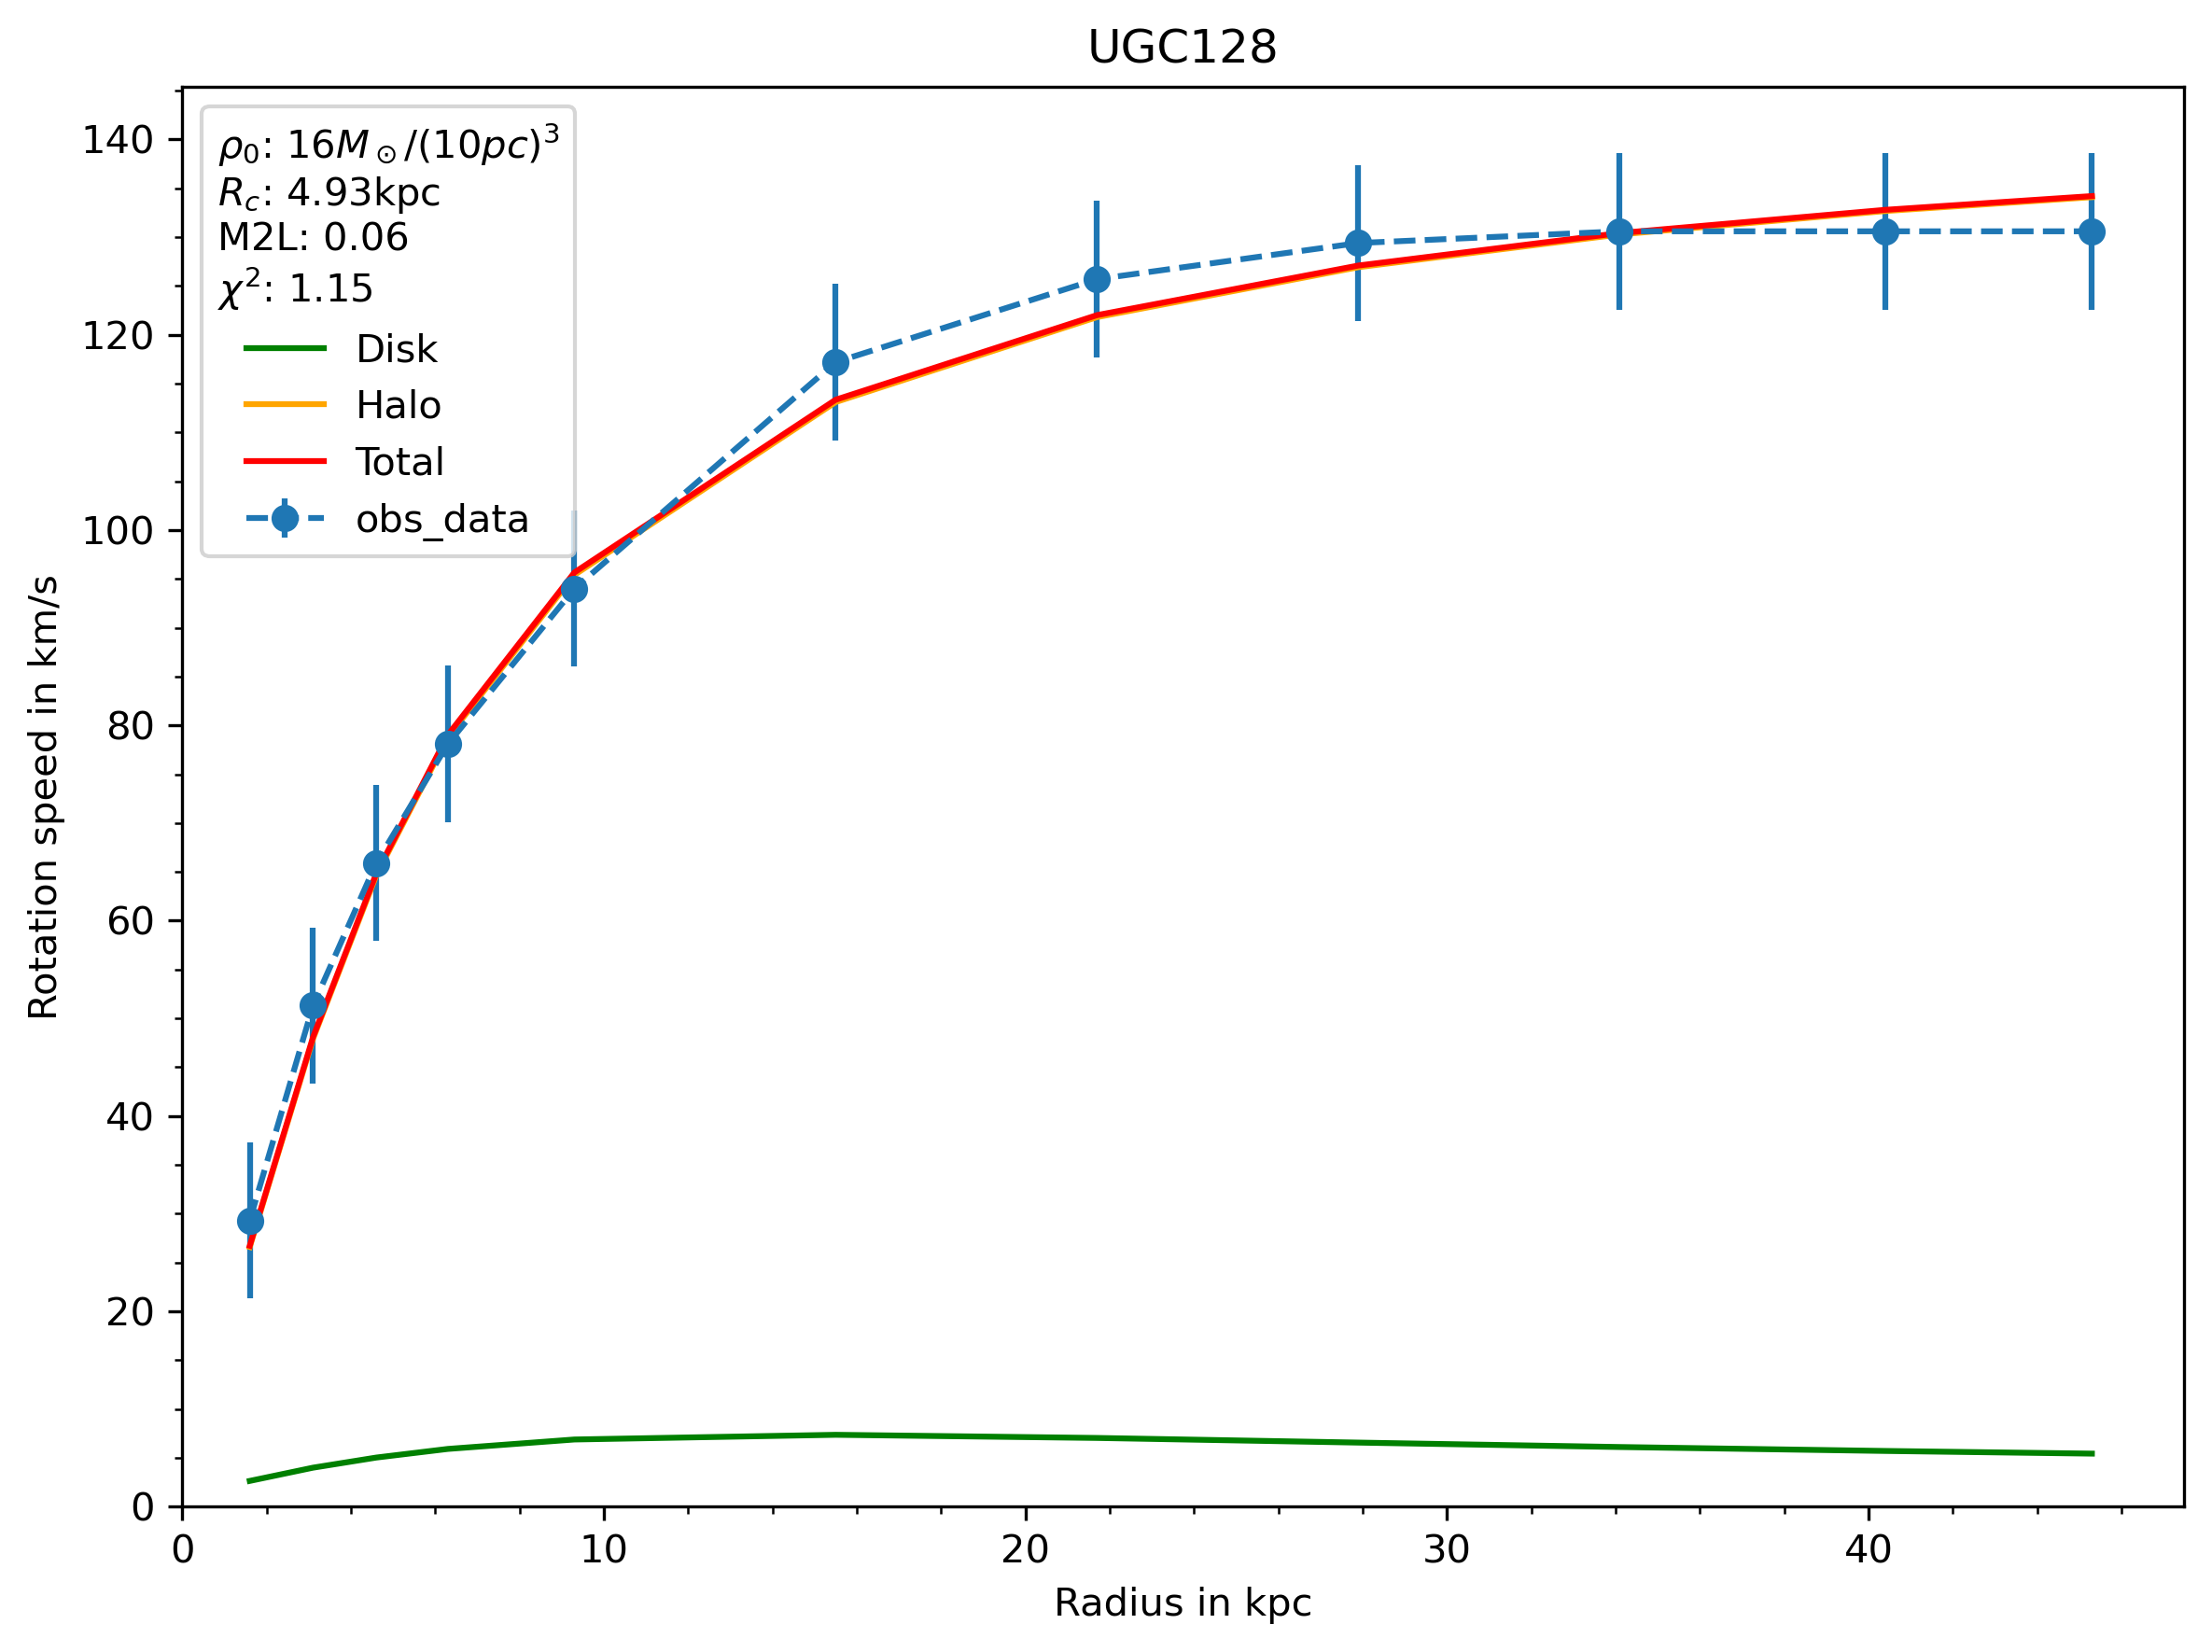

In [116]:
get_plot(df,popt,chi2,title_str='UGC128')

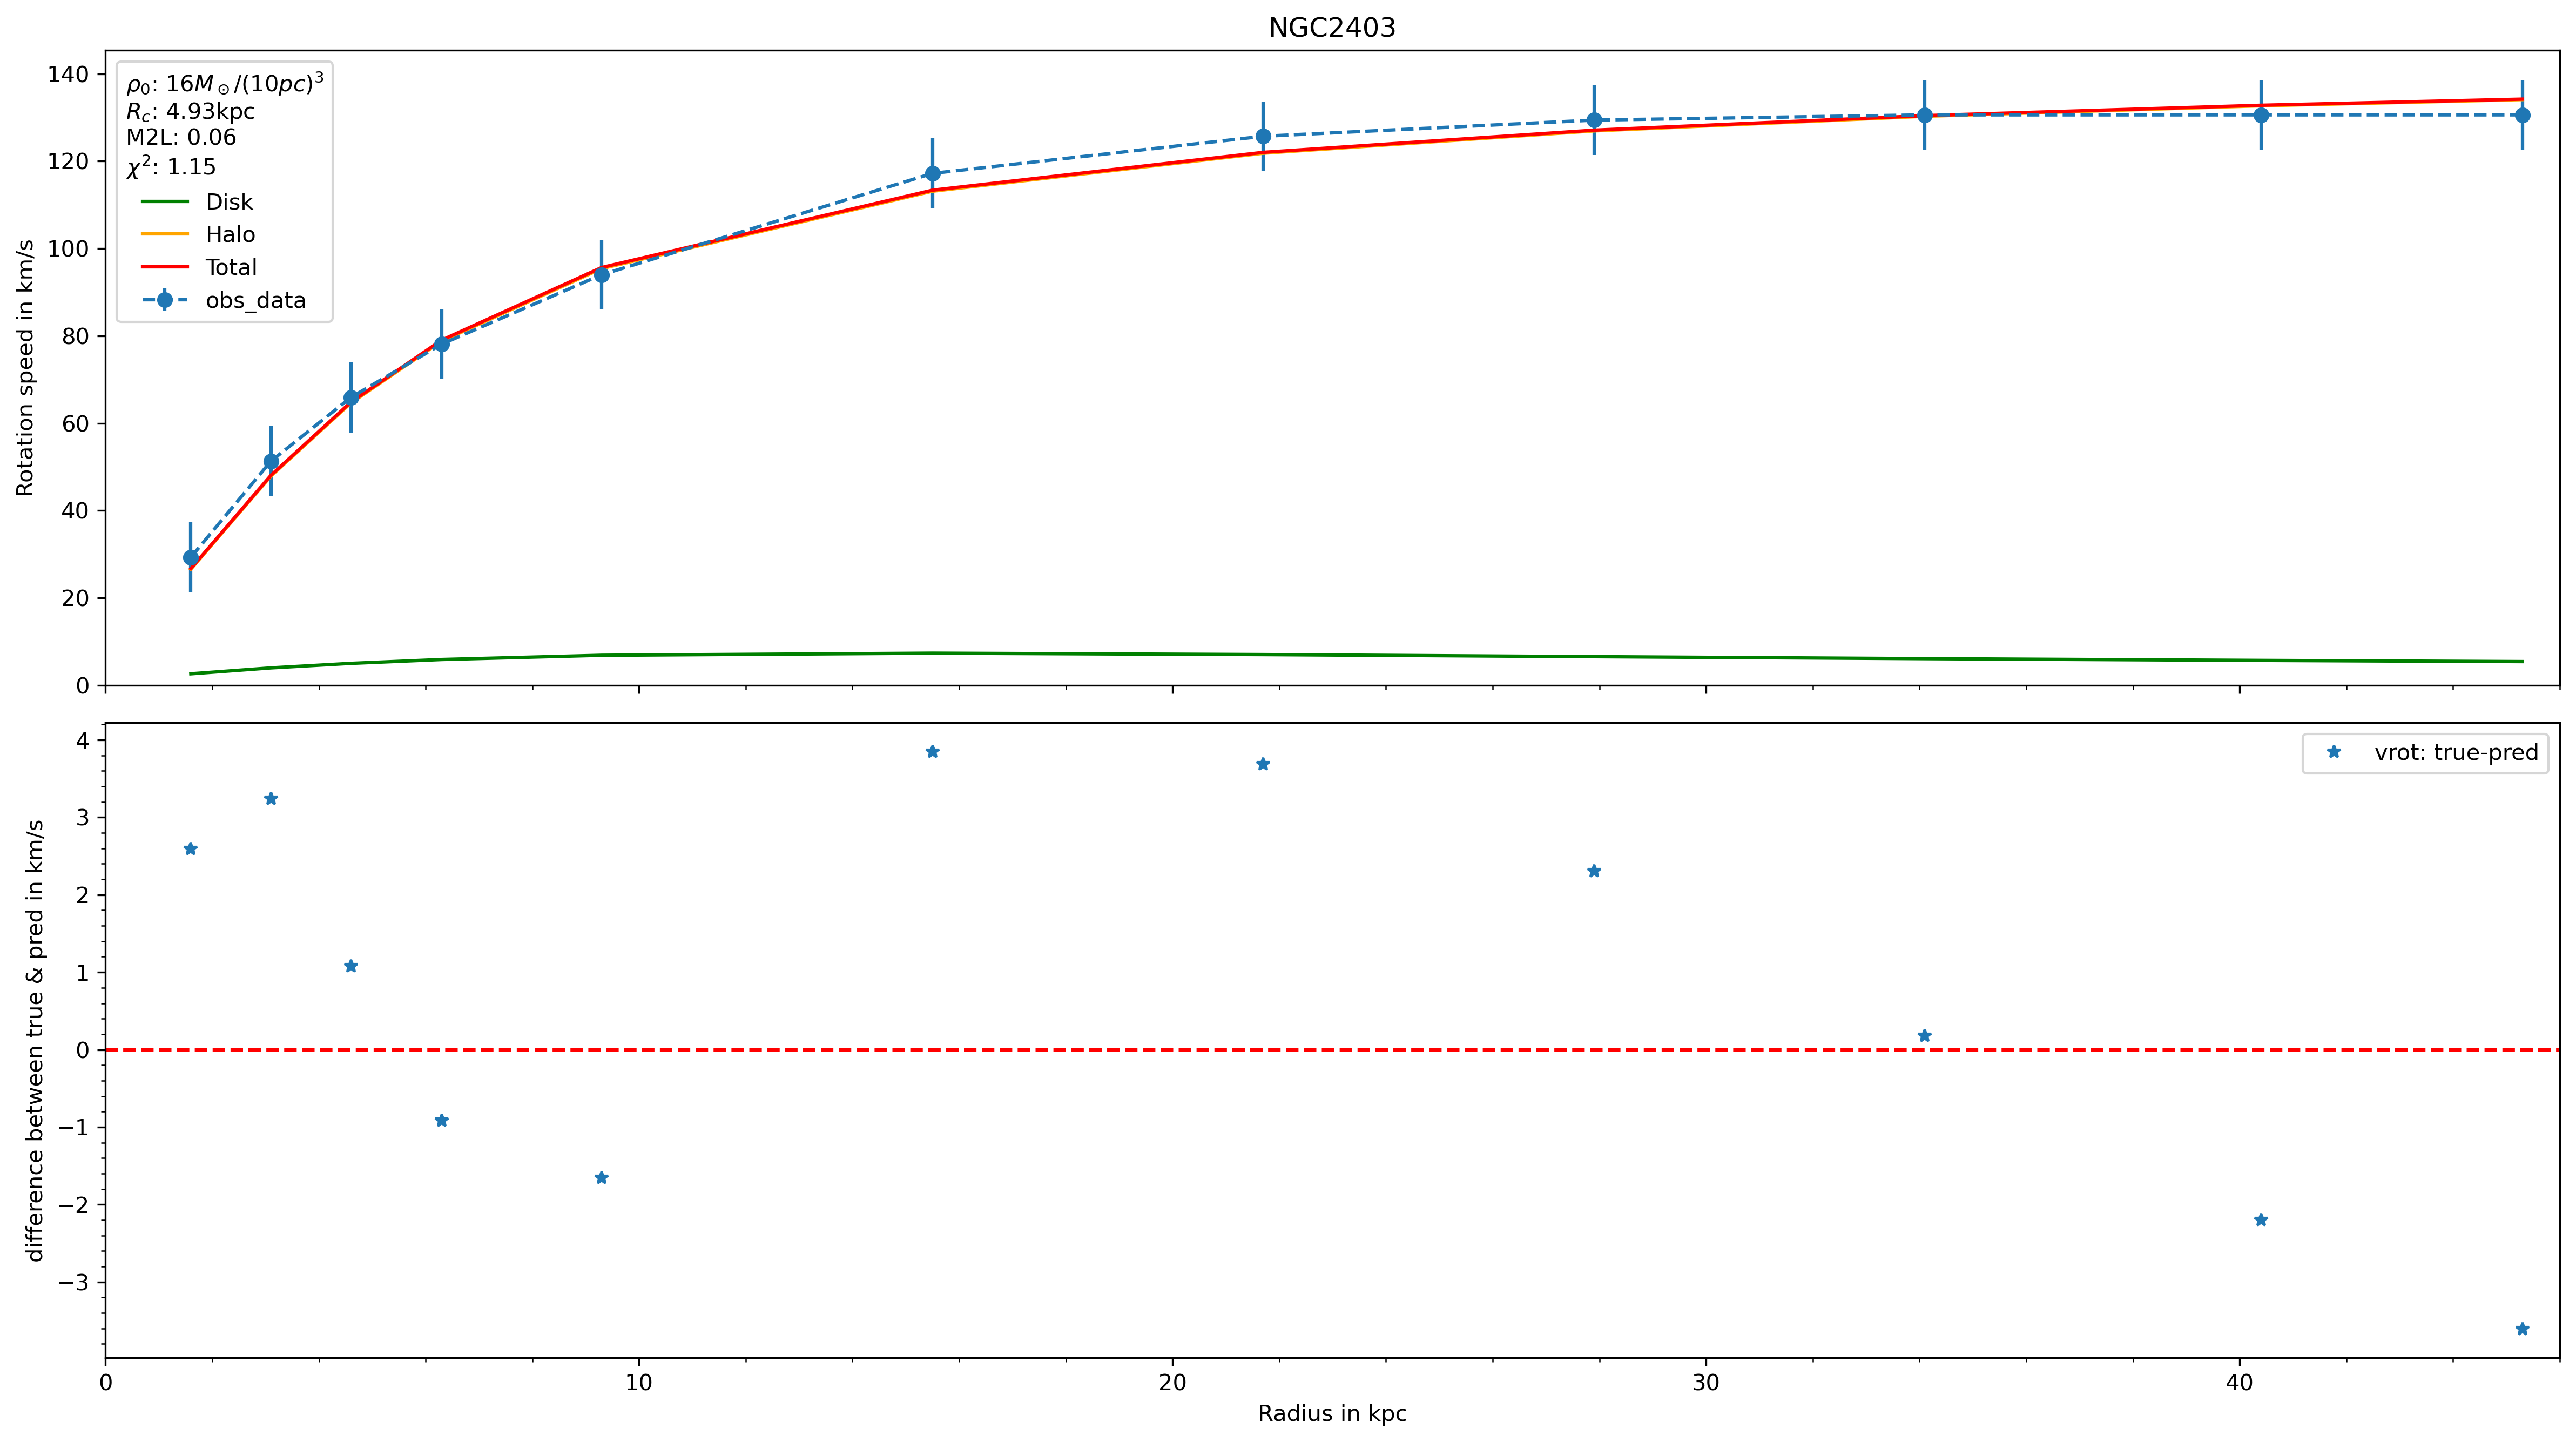

In [117]:
get_plot_with_diff(df,popt,chi2,title_str='NGC2403',xlim=(0,46))